In this notebook, I try to take a first look at the data from Ehrlich & Schoppik (2017). I focus on 21dpf condition (21-days-old zebrafish larvae), that is, the most mature larvae

# Read and preprocess data

In the original data, the time series is seemingly continuously recorded, but actually there are >4500 sequences of frames excluded (as explained in https://github.com/SchoppikLab/EhrlichSchoppik2016/blob/master/Preprocess_bouts_by_clutch.m). We can see it in the data by looking at the differences between consecutive timestamps, which is normally 25ms; when it's much larger, it means that there is a break in the data

In [1]:
import os
import helper_functions as helper
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import seaborn as sns

In [65]:
def append_epoch_number(data, baseline_epoch_no):    
    breaks = data[abs(data['delta_t']) > 0.05]
    data['epoch'] = 0
    previous_idx = 0
    epoch_no = baseline_epoch_no + 1
    for idx, row in breaks.iterrows():
        data.loc[(data.index>=previous_idx) & (data.index<idx), 'epoch'] = epoch_no
        previous_idx = idx
        epoch_no += 1
    data.loc[data.index>previous_idx, 'epoch'] = epoch_no 
    return data

def get_data(data_path):    
    dfs = []
    baseline_epoch_no = 0
    for clutch in range(1,5):
        file_path = os.path.join(data_path, 'Clutch_%i_data.mat' % (clutch))
        mat_data = helper.loadmat(file_path)
        df = pd.DataFrame({'t': mat_data['HeadingMatchedTimes']*3600, 
                             'theta': mat_data['HeadingMatchedAngles'], # np.radians(data['HeadingMatchedAngles']),
                             'v': mat_data['HeadingMatchedSpeeds']})
        df['delta_t'] = np.concatenate([[0.025], np.diff(df.t)])    
        df['clutch'] = clutch
        df = append_epoch_number(df, baseline_epoch_no)
        baseline_epoch_no = df.iloc[-1].epoch
        dfs.append(df)
    data = pd.concat(dfs)
    data = data.astype({'epoch': int})
    
    return data

with open('data_path.txt', 'r') as f:
    data_path = os.path.join(f.readline(), 'zebrafish')

data = get_data(data_path)

Angular velocity in the original data is very noisy, we use noise-robust numerical differentiation to reconstruct angular velocity (omega) from the original pitch angle values

In [67]:
def append_derivatives(dynamics):
    names = {'v': 'a',
             'theta': 'omega',
             'omega': 'alpha'}

    for col_name, der_name in names.items():
        dynamics[der_name] = np.concatenate(
                [helper.differentiate(traj['t'].values, traj[col_name].values)
                        for traj_id, traj in dynamics.groupby(level=dynamics.index.names, 
                                                              group_keys=False)]
                )

    return dynamics

epoch_lengths = data.groupby('epoch').apply(lambda t: len(t))
short_epochs = epoch_lengths[epoch_lengths<40].index
data = data[~(data.epoch.isin(short_epochs))]
data = data.set_index('epoch')
data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))

data = append_derivatives(data)

Plot example trajectory, and compare it to the same data smoothed using the Savitzky-Golay filter (window length and polyorder parameters needed a bit of calibration, 7 and 2 respectively worked well)

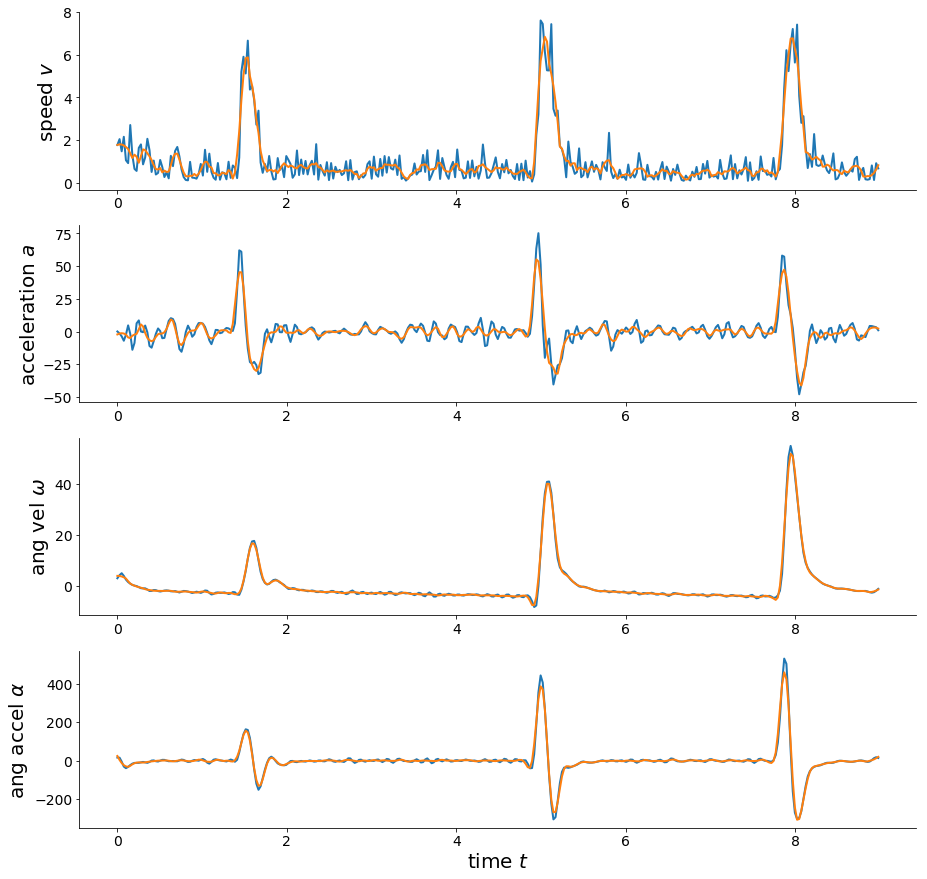

In [68]:
traj = data.loc[180]

window_length = 9
polyorder = 2

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
ax1.plot(traj.t, traj.v)
v_smooth = savgol_filter(traj.v, window_length=window_length, polyorder=polyorder, axis=0)
ax1.plot(traj.t, v_smooth)
ax1.set_ylabel('speed $v$')

ax2.plot(traj.t, traj.a)
a_smooth = savgol_filter(traj.a, window_length=window_length, polyorder=polyorder, axis=0)
ax2.plot(traj.t, a_smooth)
ax2.set_ylabel(r'acceleration $a$')

ax3.plot(traj.t, traj.omega)
omega_smooth = savgol_filter(traj.omega, window_length=window_length, polyorder=polyorder, axis=0)
ax3.plot(traj.t, omega_smooth)
ax3.set_ylabel(r'ang vel $\omega$')

ax4.plot(traj.t, traj.alpha)
alpha_smooth = savgol_filter(traj.alpha, window_length=window_length, polyorder=polyorder, axis=0)
ax4.plot(traj.t, alpha_smooth)
ax4.set_ylabel(r'ang accel $\alpha$')

ax4.set_xlabel('time $t$');

Apply the filter to all trajectories

In [69]:
apply_filter = lambda traj: savgol_filter(traj, window_length=7, polyorder=2, axis=0)
cols_to_smooth = ['v', 'a', 'theta', 'omega', 'alpha']
data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

Finally, we detect passive phases using angular acceleration, and save the results to a csv file

In [70]:
def save_passive_phases(data):
    dfs = []
    for epoch_no, epoch_data in data.groupby('epoch'):
#         starting_points, action_points = helper.extract_passive_phases(epoch_data.v.values, threshold=3)
#         starting_points, action_points = helper.extract_passive_phases(epoch_data.alpha.values, threshold=50)
        starting_points, action_points = helper.extract_passive_phases(epoch_data.a.values, threshold=20)
        df = pd.DataFrame({'epoch_no': epoch_no,
                           'passive_phase_number': np.arange(1, len(starting_points)+1),
                           'idx_sp': starting_points,
                           'idx_ap': action_points,
                           't_sp': epoch_data.iloc[starting_points].t.values, 
                           't_ap': epoch_data.iloc[action_points].t.values,
                           'theta_sp': epoch_data.iloc[starting_points].theta.values,
                           'theta_ap': epoch_data.iloc[action_points].theta.values,
                           'omega_sp': epoch_data.iloc[starting_points].omega.values,
                           'omega_ap': epoch_data.iloc[action_points].omega.values
                          })
        dfs.append(df)
    
    passive_phases = pd.concat(dfs)
              
    passive_phases = passive_phases.astype({'epoch_no': 'int64', 
                                            'passive_phase_number': 'int64', 
                                            'idx_sp': 'int64',
                                            'idx_ap': 'int64'})

    passive_phases['delta_t'] = passive_phases['t_ap'] - passive_phases['t_sp']
    
    # if we're determining passive phases based on acceleration, there's going to be many very short pp's
    passive_phases = passive_phases[passive_phases.delta_t>0.25]
    passive_phases['delta_theta'] = passive_phases['theta_ap'] - passive_phases['theta_sp']
    passive_phases['delta_omega'] = passive_phases['omega_ap'] - passive_phases['omega_sp']    

    passive_phases.to_csv(os.path.join(data_path, 'passive_phases.csv'), float_format='%.5f', index=False)

save_passive_phases(data)

Just in case, here is a stub for the function which should look specifically at acceleration to determine passive phases, withouth the trick of discarding short passive phases after standard extraction. This is not usable at the moment, might be helpful in future

In [71]:
def extract_passive_phases_acc(a, threshold=15):
    starting_points = []
    action_points = []
    # what to do when we start already in the active phase?
    is_in_active_phase = abs(a[0]) > threshold
    is_before_first_zero_cross = False
    for i in np.arange(1,len(a)-1):
        if is_in_active_phase:
            # iterate until we encounter the first zero-cross point
            if is_before_first_zero_cross & (a[i]*a[i-1] < 0):
                is_before_first_zero_cross = True
            # after that, iterate until we encounter the first value less then a threshold
            if not is_before_first_zero_cross & abs(a[i+1]) > threshold:
                is_before_first_zero_cross = False
        else:
            if (abs(a[0]) > threshold):
                is_in_active_phase = True
                action_points += [i]                
        
        if abs(a[i])<=threshold:
            if not is_previous_v_zero:
                is_previous_v_zero = True
                starting_points += [i]
#            elif (i==len(v)-1):
#                action_points += [i]            
        elif (is_previous_v_zero):
            action_points += [i]
            is_previous_v_zero = False
    # This is needed if the recording ends in the passive control phase
    if len(action_points) < len(starting_points):
        starting_points = starting_points[:-1]
    return starting_points, action_points

# Inspect detected passive phases

In [72]:
passive_phases = pd.read_csv(os.path.join(data_path, 'passive_phases.csv'), index_col='epoch_no')

Look at the example trajectory with passive phases indicated by markers

In [160]:
def get_traj(epoch_no, data, passive_phases):
    traj = data.loc[epoch_no]
    epoch_passive_phases = passive_phases.loc[epoch_no]
    if (type(epoch_passive_phases) == pd.core.series.Series):
        epoch_passive_phases = pd.DataFrame(epoch_passive_phases).T
    return traj, epoch_passive_phases

epoch_no = 15
traj, epoch_passive_phases = get_traj(epoch_no, data, passive_phases)

In [161]:
epoch_passive_phases

,passive_phase_number,idx_sp,idx_ap,t_sp,t_ap,theta_sp,theta_ap,omega_sp,omega_ap,delta_t,delta_theta,delta_omega
epoch_no,,,,,,,,,,,,
15,1,0,11,0.000,0.278,-11.00179,-12.99005,-2.92659,-4.42908,0.278,-1.98826,-1.50249
15,2,21,31,0.530,0.782,3.49390,7.68124,28.92398,9.26981,0.252,4.18733,-19.65417
15,4,38,59,0.959,1.489,-7.28681,-12.98657,-34.05560,-12.30492,0.530,-5.69976,21.75068
15,6,68,87,1.716,2.195,-14.18919,-20.26829,4.94863,-19.94708,0.479,-6.07910,-24.89571
15,8,98,116,2.473,2.927,-3.24610,-2.94362,10.78189,-7.16726,0.454,0.30248,-17.94915
15,9,125,138,3.153,3.481,-7.71190,-9.87948,-9.16127,-7.00100,0.328,-2.16757,2.16027


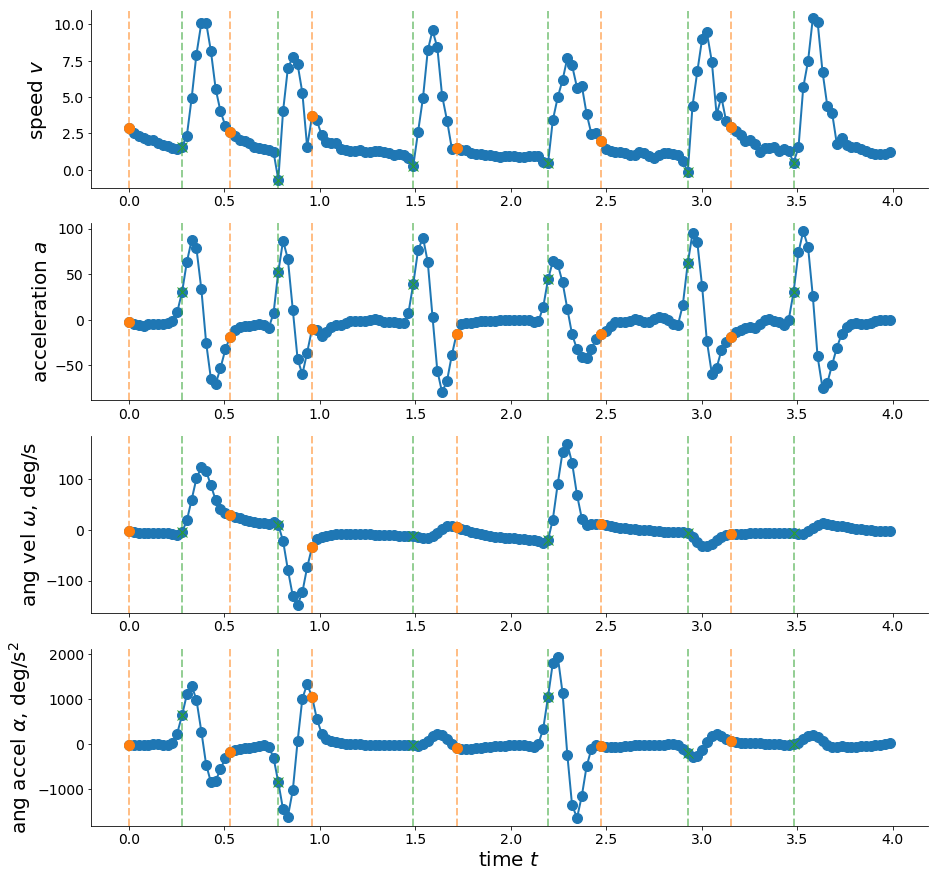

In [162]:
def plot_epoch(traj, epoch_passive_phases):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15))

    ax1.plot(traj.t, traj.v, marker='o')
    ax2.plot(traj.t, traj.a, marker='o')
    ax3.plot(traj.t, traj.omega, marker='o')
    ax4.plot(traj.t, traj.alpha, marker='o')

    for i, pp in epoch_passive_phases.iterrows():
        t = traj.t.values
        v = traj.v.values
        a = traj.a.values        
        omega = traj.omega.values
        alpha = traj.alpha.values

        pp = pp.astype('int64')
        ax1.plot(t[pp.idx_sp], v[pp.idx_sp], ls='', marker='o', color='C1')
        ax1.plot(t[pp.idx_ap], v[pp.idx_ap], ls='', marker='x', color='C2')
        ax2.plot(t[pp.idx_sp], a[pp.idx_sp], ls='', marker='o', color='C1')
        ax2.plot(t[pp.idx_ap], a[pp.idx_ap], ls='', marker='x', color='C2')        
        ax3.plot(t[pp.idx_sp], omega[pp.idx_sp], ls='', marker='o', color='C1')
        ax3.plot(t[pp.idx_ap], omega[pp.idx_ap], ls='', marker='x', color='C2')
        ax4.plot(t[pp.idx_sp], alpha[pp.idx_sp], ls='', marker='o', color='C1')
        ax4.plot(t[pp.idx_ap], alpha[pp.idx_ap], ls='', marker='x', color='C2')

        for ax in (ax1, ax2, ax3, ax4):
            ax.axvline(x=t[pp.idx_sp], color='C1', ls='--', alpha=0.5)
            ax.axvline(x=t[pp.idx_ap], color='C2', ls='--', alpha=0.5)

    ax1.set_ylabel('speed $v$')
    ax2.set_ylabel('acceleration $a$')
    ax3.set_ylabel(r'ang vel $\omega$, deg/s')
    ax4.set_ylabel(r'ang accel $\alpha$, deg/s$^2$')
    ax4.set_xlabel('time $t$');
    
plot_epoch(traj, epoch_passive_phases)

# Analyzing passive phases

In [87]:
passive_phases = pd.read_csv(os.path.join(data_path, 'passive_phases.csv'), index_col='epoch_no')

We have >11000 passive phases

In [77]:
len(passive_phases)

11189

First, we try to conceptually reproduce Figure 3E from Ehrlich & Schoppik (2017), which looks at the distribution of inter-event intervals (IEI), which they define as the time between consecutive peaks of translation speed. We look at a slightly different measure, $\Delta t$, which is the time between the end of a bout and the start of the next bout.

It looks like Davids ignored IEI's longer than 3 seconds, even though there are quite a lot of passive phases longer than that:

(8.93734918223255e-05, 1)

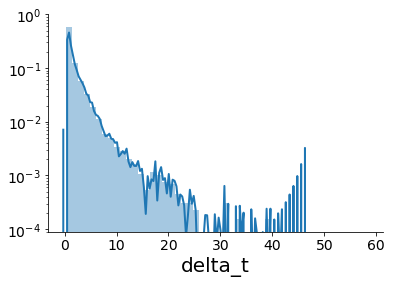

In [82]:
ax = sns.distplot(passive_phases.delta_t, kde_kws={'clip': (0.0, max(passive_phases.delta_t))})
ax.set_yscale('log')
ax.set_ylim((1/len(passive_phases), 1))

Across clutches there are 20 (0.2%) passive phases which are longer than 25 seconds

In [88]:
print(len(passive_phases[passive_phases.delta_t>25])/len(passive_phases))
print(len(passive_phases[passive_phases.delta_t>25]))

0.00178746983644651
20


Temporarily excluding these outliers, we can take a closer look at the distribution of $\Delta t$. It's somewhere between exponential and Pareto distributions...

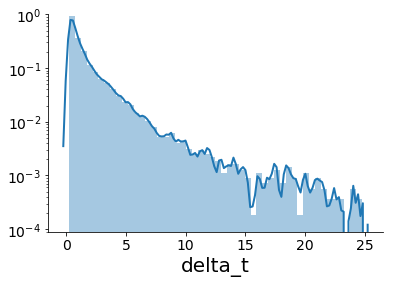

In [89]:
ax = sns.distplot(passive_phases[passive_phases.delta_t<25].delta_t, kde_kws={'clip': (0.0, max(passive_phases.delta_t))})
ax.set_yscale('log')
ax.set_ylim((1/len(passive_phases), 1));

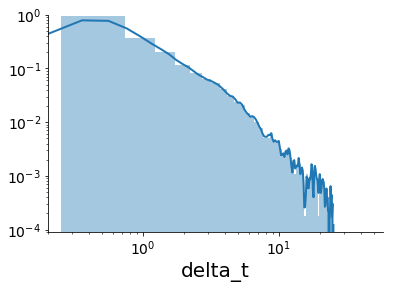

In [91]:
ax = sns.distplot(passive_phases[passive_phases.delta_t<25].delta_t, kde_kws={'clip': (0.2, max(passive_phases.delta_t))})
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.2, max(passive_phases.delta_t)))
ax.set_ylim((1/len(passive_phases), 1));

Now, let's look at joint distribution of pitch angle $\theta$ and angular velocity $\omega$ at the time of bout onset. This is different from  Figure 4A from the original paper, because they look at relative likelihood of a bout, taking into account the probability of observing a given combination of $\theta$ and $\omega$

There are a few clear outliers with very high $\omega_{AP}$, let's exclude them

In [100]:
passive_phases = passive_phases[passive_phases.omega_ap>-100]

After exclusion, look at joint probability of bout initiation depending on $\theta$ and $\omega$

Text(13.625, 0.5, '$\\omega_{AP}$')

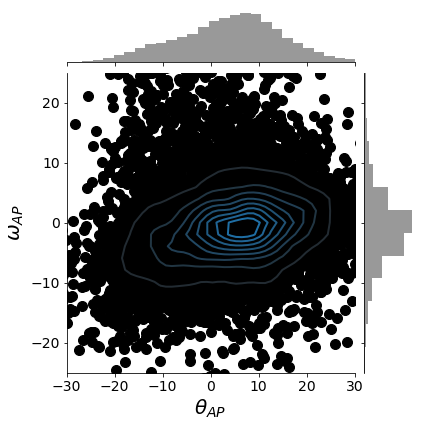

In [143]:
g = sns.jointplot('theta_ap', 'omega_ap', data=passive_phases, color='k', xlim=(-30,30), ylim=(-25,25))
g.plot_joint(sns.kdeplot)
g.ax_joint.set_xlabel(r'$\theta_{AP}$')
g.ax_joint.set_ylabel(r'$\omega_{AP}$')

Here already we see that bouts are more likely to be initiated when the fish is nose-up ($\theta>0$)

The original paper also emphasizes that the larvae preferes to maintain a noise-up posture. Table S2 mentions that in 21dpf larvae, the mean pitch angle is 4.6 degress. I have a slightly larger estimate here, 5.0 degrees; not sure where this 10% discrepancy comes from...

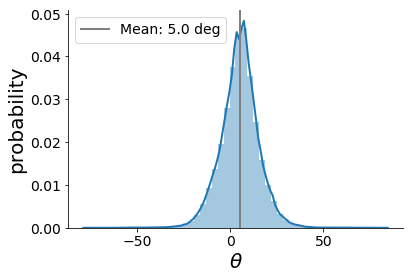

In [145]:
ax = sns.distplot(data.theta)
ax.axvline(data.theta.mean(), color='grey', label='Mean: %.1f deg' % (data.theta.mean()))
ax.legend(fontsize=14)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('probability');

In any case, the exact value of the preferred angle is important for modeling: the drift rate in an evidence accumulation model would arguably be proportional to $\theta-\theta_{\text{preferred}}$

A similar analysis of $\omega$ distribution is interesting though: its mean value across all recorded data is -$0.5$ deg/s; this probably indicates that although the fish would ideally remain stationary ($\omega=0$), the gravity pulls it down during the passive phases, so on average $\omega$ is slightly negative (see also Figures 1D, 1E in the original paper).

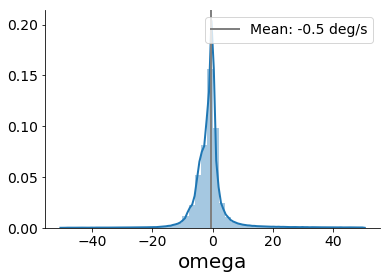

In [152]:
ax = sns.distplot(data[abs(data.omega)<50].omega)
ax.axvline(data.omega.mean(), color='grey', label='Mean: %.1f deg/s' % (data.omega.mean()))
ax.legend(fontsize=14)

I'd say that the drift rate should be proportional to $\omega$, not $\omega-\omega_{\text{preferred}}$

Looking more closely at the scatterplot of bout initation points, we calculate how many bouts were observed in each quadrant of the $\theta\omega$ plane (quadrants are separated by $\theta=5$ and $\omega=0$)

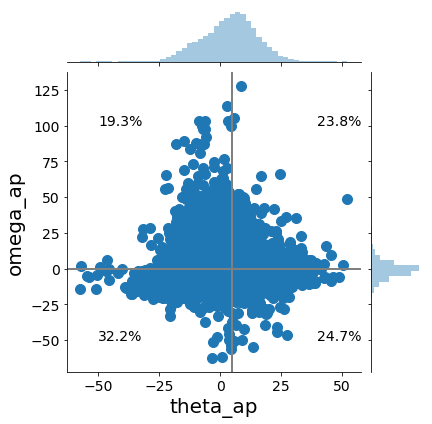

In [132]:
g = sns.jointplot(data=passive_phases, x='theta_ap', y='omega_ap')
pos_pos = len(passive_phases[(passive_phases.theta_ap>5) & (passive_phases.omega_ap>0)])/len(passive_phases)
pos_neg = len(passive_phases[(passive_phases.theta_ap>5) & (passive_phases.omega_ap<0)])/len(passive_phases)
neg_pos = len(passive_phases[(passive_phases.theta_ap<5) & (passive_phases.omega_ap>0)])/len(passive_phases)
neg_neg = len(passive_phases[(passive_phases.theta_ap<5) & (passive_phases.omega_ap<0)])/len(passive_phases)

g.ax_joint.axhline(0.0, color='grey')
g.ax_joint.axvline(5.0, color='grey')

format_str = '{rate:.1%}'
g.ax_joint.text(x=40, y=100, s=format_str.format(rate=pos_pos), fontsize=14)
g.ax_joint.text(x=40, y=-50, s=format_str.format(rate=pos_neg), fontsize=14)
g.ax_joint.text(x=-50, y=100, s=format_str.format(rate=neg_pos), fontsize=14)
g.ax_joint.text(x=-50, y=-50, s=format_str.format(rate=neg_neg), fontsize=14);

Most often the bouts are generated when a fish is "falling" nose-down and its pitch angle is less than 5 degrees (bottom left quadrant, 32.2%), which makes sense. Altogether, about 50% of bouts are initiated when angle is less than 5 degrees, and the remaining 50% when the angle is > 5 degrees.

In [135]:
len(passive_phases[passive_phases.theta_ap<5])/len(passive_phases)

0.5149293760057214